In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Read the data and skip the first two rows as they have no valuable data
df = pd.read_csv("NVIDIA_STOCK.csv", skiprows=[1, 2])

# Renaming columns and changing date data type to Date
df = df.rename(columns={"Price": "Date"})
df = df.rename(columns={"Adj Close": "AdjClose"})
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

#Dropping the irrelevant features (Close = closing price)
df = df.drop(columns=["Close"])

#Creating a 7 day and a 30 day moving averages for features
df['MA_7'] = df['AdjClose'].rolling(window=7).mean()
df['MA_30'] = df['AdjClose'].rolling(window=30).mean()
df.dropna(inplace=True)

#Setting the index as Date
df = df.set_index('Date')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1668 entries, 2018-02-13 to 2024-09-30
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   AdjClose  1668 non-null   float64
 1   High      1668 non-null   float64
 2   Low       1668 non-null   float64
 3   Open      1668 non-null   float64
 4   Volume    1668 non-null   int64  
 5   MA_7      1668 non-null   float64
 6   MA_30     1668 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 104.2 KB


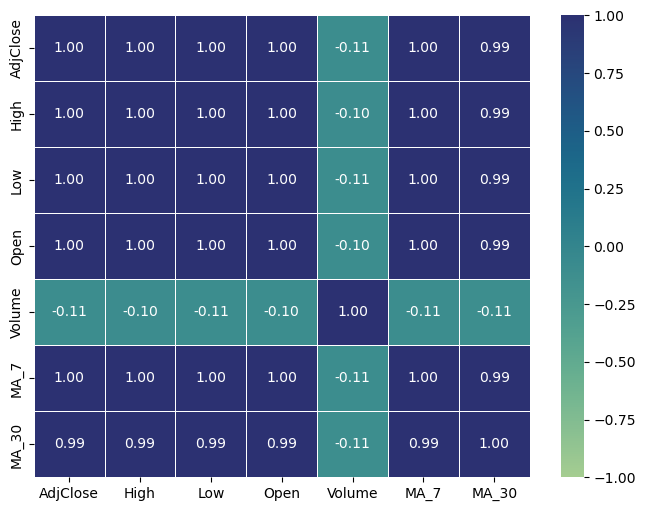

In [2]:
#heatmap
cor = df.corr()
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cor, ax=ax, annot=True, fmt=".2f", cmap="crest", vmin=-1, vmax=1, center=0, linewidths=0.5, linecolor="white")
plt.show()

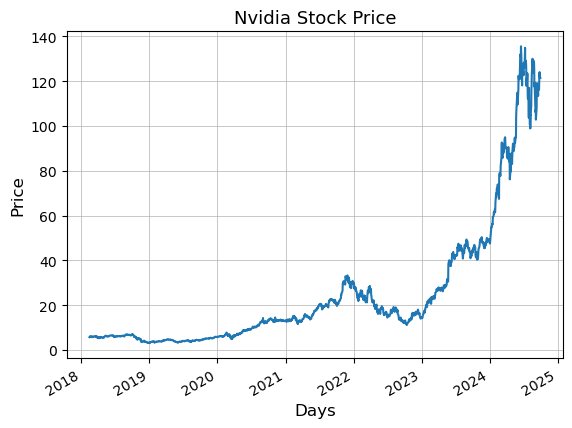

,AdjClose,High,Low,Open,Volume,MA_7,MA_30
Date,,,,,,,
2018-02-13,5.752888,5.86250,5.63125,5.66400,625524000,5.576000,5.630707
2018-02-14,5.970263,6.06475,5.76375,5.77500,744988000,5.673930,5.665386
2018-02-15,6.095891,6.20925,6.03800,6.11975,698900000,5.747836,5.693438
2018-02-16,6.030109,6.25000,6.08675,6.13500,637656000,5.800970,5.718374
2018-02-20,6.159693,6.29675,6.11500,6.11875,686240000,5.912466,5.746137


In [3]:
#Visual of Closing price
df['AdjClose'].plot()
plt.title("Nvidia Stock Price", fontsize=13)
plt.ylabel('Price', fontsize=12)
plt.xlabel('Days', fontsize=12)
plt.grid(linewidth=0.5)
plt.show()
df.head()

In [4]:
#features and label
features = ["Open","High","Low","Volume","MA_7","MA_30"]
X = df[features]
y = df["AdjClose"]

#Splitting the data
n = len(df)
train_end = int(0.6 * n)
val_end = int(0.8 * n)

X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
X_test, y_test = X.iloc[val_end:], y.iloc[val_end:]

# Shape for train data and validation data
print('Train:', X_train.shape)
print('Validation:', X_val.shape)
print('Test:', X_test.shape)

Train: (1000, 6)
Validation: (334, 6)
Test: (334, 6)


In [5]:
#Training and fitting the model
model = LinearRegression()
model.fit(X_train, y_train)

#Creating RMSE
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

# making predictions
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

In [6]:
#Evaluating the model
print('Training Mean Squared Error:', mean_squared_error(y_train,y_train_pred))
print("Training RMSE: ", rmse(y_train,y_train_pred))
print(" ")
print('Validation Mean Squared Error:', mean_squared_error(y_val,y_val_pred))
print("Validation RMSE: ", rmse(y_val,y_val_pred))
print(" ")
print('Test Mean Squared Error:', mean_squared_error(y_test,y_test_pred)) 
print("Test RMSE: ", rmse(y_test,y_test_pred))

Training Mean Squared Error: 0.02370190383959963
Training RMSE:  0.15395422644279574
 
Validation Mean Squared Error: 0.07299355829653828
Validation RMSE:  0.2701732005520501
 
Test Mean Squared Error: 0.9487889436114281
Test RMSE:  0.9740579775410846


In [7]:
#Creating new dataframe to actual and predicted prices
df_pred = pd.DataFrame(y_test.values, columns=['Actual'], index=y_test.index)
df_pred['Predicted'] = y_test_pred
df_pred = df_pred.reset_index()
df_pred

,Date,Actual,Predicted
0,2023-06-02,39.305092,39.505539
1,2023-06-05,39.149181,39.390541
2,2023-06-06,38.632465,38.695582
3,2023-06-07,37.457993,38.217230
4,2023-06-08,38.492531,38.592285
...,...,...,...
329,2024-09-24,120.861671,119.718566
330,2024-09-25,123.501495,123.755583
331,2024-09-26,124.031456,123.036271
332,2024-09-27,121.391640,120.192531


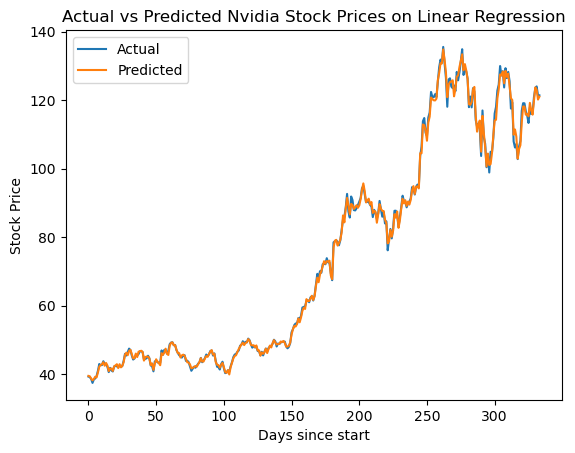

In [8]:
#Plotting actual and predicted prices on test set
df_pred[['Actual', 'Predicted']].plot()
plt.xlabel('Days since start')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Nvidia Stock Prices on Linear Regression')
plt.show()

Text(0.5, 1.0, 'Last 15 prices')

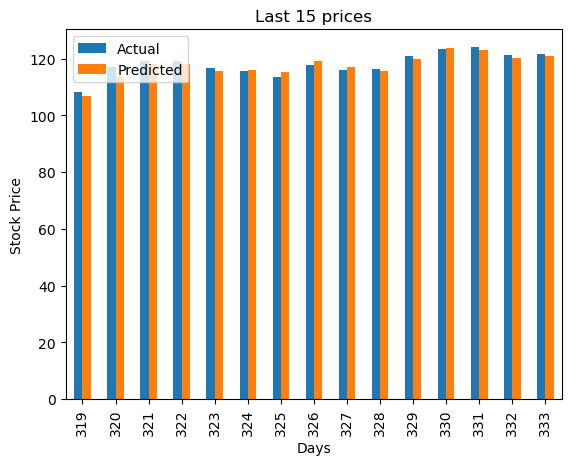

In [9]:
#Graph of the last 15 values
graph = df_pred[['Actual', 'Predicted']].tail(15)
graph.plot(kind='bar')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Last 15 prices')

In [10]:
#Prediction for the next day after the dataset has ended
model.fit(X.iloc[:-1], y.iloc[:-1])
X_last = X.iloc[[-1]]
last_date = df.index[-1]
next_pred = model.predict(X_last)[0]
print(next_pred)

121.10904516679523
